# NLP: Product Comment Sentiment Analysis

**Resources**
*   https://www.geeksforgeeks.org/what-is-sentiment-analysis/ (intro)
*   tutorial guides 
    >  https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

    >  https://towardsdatascience.com/text-classification-using-k-nearest-neighbors-46fa8a77acc5

    >  https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

    > https://medium.com/@ashins1997/text-classification-456513e18893

*   vader lexicon tutorial - for sentiment analysis (https://youtu.be/9p1KYtYAus8 & https://youtu.be/QpzMWQvxXWk?feature=shared)
*   dataset downloaded from https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis

<br><br>

Documents (bg study, methods etc will do later)

* Step 1: Get data (csv file)

* Step 2: Pre-processing. Tokenize, Lemmatize, remove stopwords, punctuations etc, then do sentiment analysis

* Step 3: Count vectorizer (frequency each words appeared), then identify similarity (use cosine similarity equation, correlation etc.)

* Step 4: each of us will choose our preferred method (bayes, knn, k-means)

* Step 5: compare the results (from using different methods)


# Getting Data & Setup


In [55]:
# install nltk (terminal line commands)
%pip install nltk
%pip install pandas
%pip install -U scikit-learn

import nltk
import math
import site
import pandas as pd    # to allow us to read csv file
import random
import numpy as np
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import genesis
from nltk.tokenize import word_tokenize # for tokenization of words
from nltk import pos_tag # For lemmatizer, require Pos tags to understand form of word (noun, verb, adj)
from nltk.stem import WordNetLemmatizer # for lemmatization
from sklearn.metrics import confusion_matrix # confusion matrix (evaluate performance of nltk sentiment analyzer)
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split # used in naive bayes, svm, knn, logistic regresssion (split data into: train, test)
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, naive_bayes, svm
from collections import defaultdict
from sklearn import preprocessing # includes encoder from preprocessing module

plt.style.use('ggplot')
nltk.download('all')
site.getsitepackages() # to find our current path, we imported site, and getsitepackages()

# KNN
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

True

# Read data

In [27]:
data = pd.read_csv('AllProductReviews.csv')
# nrows is to limit the data rows that we wanted to take out
# data = pd.read_csv('AllProductReviews.csv', nrows=3000) 

In [3]:
# data.head()
total = data.count()
print(total)

ReviewTitle    14337
ReviewBody     14337
ReviewStar     14337
Product        14337
dtype: int64


Shows the Ratings by the reviewers

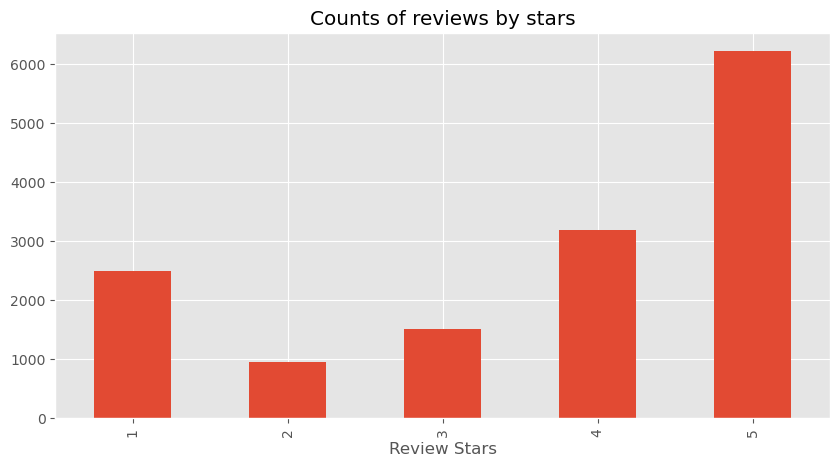

In [28]:
# to indicate how many rating is occupied
ax = data['ReviewStar'].value_counts().sort_index().plot(kind='bar', title= 'Counts of reviews by stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show() # show bar chart

# Pre-Processing

In [36]:
# create pre processing function
def preprocess_data(text):

  # tokenize the text (and make it lowercase)
  tokens = word_tokenize(text.lower())

  # remove stop words
  filtered_tokens = [token for token in tokens if token not in stopwords.words('english') and token.isalpha()] # check for stopwords, only alphabets accepted

  # lemmatize the tokens
  lemmatizer = WordNetLemmatizer() # initialize WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  #Join the tokens back into a string
  processed_text = ' '.join(lemmatized_tokens)

  return processed_text

# remove blank rows from data
data['ReviewBody'].dropna(inplace=True)
data['ReviewBody'] = data['ReviewBody'].astype(str) # convert data to 'string' data type

# Preprocess_data
# create a column called 'tokenized'
data['Processed'] = data.apply(lambda x: preprocess_data(x['ReviewBody']), axis=1) # applying the preprocess_data function to the 'COMMENTS' column of  the DataFrame
data # display resulting table

,ReviewTitle,ReviewBody,ReviewStar,Product,Processed,Polarity,Sentiment
0,Honest review of an edm music lover\r\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,doubt great bass great extent noise cancellati...,1,1
1,Unreliable earphones with high cost\r\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,earphone unreliable bought day meanwhile right...,1,1
2,Really good and durable.\r\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,bought itfor purchased second time gifted firs...,1,1
3,stopped working in just 14 days\r\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,sound quality adorable overall good week stopp...,1,1
4,Just Awesome Wireless Headphone under 1000...😉...,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,awesome good sound quality hr battery life waw...,1,1
...,...,...,...,...,...,...,...
14332,Good\r\n,Good\r\n,4,JBL T110BT,good,1,1
14333,Amazing Product\r\n,An amazing product but a bit costly.\r\n,5,JBL T110BT,amazing product bit costly,1,1
14334,Not bad\r\n,Sound\r\n,1,JBL T110BT,sound,0,0
14335,a good product\r\n,the sound is good battery life is good but the...,5,JBL T110BT,sound good battery life good wire long good pr...,1,1


# Sentiment Analysis

In [30]:
# creating NLTK sentiment analyzer (via nltk.sentiment.vader library)
analyzer = SentimentIntensityAnalyzer()

# create get_positive_score function
def get_positive_score(text):
    # take text string as input, get sentiment scores pos/neg/neutral (dictionary data type {key:value}) using polarity_scores method
    # polarity score includes score for pos, neg, and neutral (assign sentiment value depending on whether positive score is +ve or - ve, values above 0 classified positive)

    scores = analyzer.polarity_scores(text) # sentiment scores (pos, neg, neutral) parse as dictionary type into scores (accessed later as scores[key])
    positive_score = math.ceil(scores['pos']) # ceil() rounds score to the next greater nearest integer. E.g 0.201 round to 1, -0.2 round to 0

    return positive_score

# create get_sentiment function
def get_sentiment(text):

    scores = analyzer.polarity_scores(text) # sentiment scores (pos, neg, neutral) parse as dictionary type into scores (accessed later as scores[key])
    sentiment = 1 if scores['pos'] > 0 else 0 # assign sentiment score based on text's POSITIVE score 
   
    return sentiment

 # create new column called 'Positive' and apply get_sentiment function
data['Polarity'] = data['ReviewBody'].apply(get_positive_score)

# create new column called 'sentiment' and apply get_sentiment function
data['Sentiment'] = data['ReviewBody'].apply(get_sentiment) # applying the get_sentiment function to each value in the 'COMMENTS' column (row by row)


data # display table





,ReviewTitle,ReviewBody,ReviewStar,Product,Processed,Polarity,Sentiment
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,doubt great bass great extent noise cancellati...,1,1
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,"earphone unreliable , bought 15 day meanwhile ...",1,1
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,"bought itfor 999 , purchased second time , gif...",1,1
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,sound quality adorable . overall good 2 week s...,1,1
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,awesome ... good sound quality & 8-9 hr batter...,1,1
...,...,...,...,...,...,...,...
14332,Good\n,Good\n,4,JBL T110BT,good,1,1
14333,Amazing Product\n,An amazing product but a bit costly.\n,5,JBL T110BT,amazing product bit costly .,1,1
14334,Not bad\n,Sound\n,1,JBL T110BT,sound,0,0
14335,a good product\n,the sound is good battery life is good but the...,5,JBL T110BT,sound good battery life good wire long 's good...,1,1


# Testing

### Confusion Matrix

In [7]:
# check performance of sentiment analyzer

# confusion_matrix is a function evaluates the performance of a classification model by comparing the predicted labels with the actual labels (pass two arguments, data['Positive'] and data['Sentiment'].)
# shows the number of true positives, false positives, true negatives, and false negatives (The rows of the matrix represent the actual labels, while the columns represent the predicted labels)
# diagonal elements of the matrix represent the number of correct predictions, while the off-diagonal elements represent the number of incorrect predictions.

print(confusion_matrix(data['Polarity'], data['Sentiment'])) # have test data and prediction data
print("_______" * 8)
print(classification_report(data['Polarity'], data['Sentiment']))

[[ 3440     0]
 [    0 10897]]
________________________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3440
           1       1.00      1.00      1.00     10897

    accuracy                           1.00     14337
   macro avg       1.00      1.00      1.00     14337
weighted avg       1.00      1.00      1.00     14337



### 1. Naive Bayes

Encoding to convert from char to numeric and split it into train machine and testing

In [73]:
# train the machine to distinguish the positive and negative rating based on the tokens
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data['Sentiment']) # convert to numeric form

# test size is 30%, so that train size is 70%
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data['Processed'], encoded_labels, stratify = encoded_labels, test_size = 0.3, random_state = 42)

In [74]:
# naive bayes classifier
vector = CountVectorizer(stop_words='english', max_features = 5000) # features or input (5000 means 5000 common words are selected)
train_transData = vector.fit_transform(train_sentences) # transform parameter on the training data and transform the input by using learned parameter
test_transData = vector.transform(test_sentences)


Naive = naive_bayes.MultinomialNB()
Naive.fit(train_transData,train_labels)
predictions_NB = Naive.predict(test_transData)

# Use accuracy_score function to get the accuracy
NB_score = accuracy_score(predictions_NB, test_labels)*100
print("Naive Bayes Accuracy Score -> ", NB_score)
print("Naive Bayes classification report \n", classification_report(test_labels, predictions_NB))


Naive Bayes Accuracy Score ->  80.1255230125523
Naive Bayes classification report 
               precision    recall  f1-score   support

           0       0.65      0.38      0.48      1032
           1       0.83      0.93      0.88      3270

    accuracy                           0.80      4302
   macro avg       0.74      0.66      0.68      4302
weighted avg       0.78      0.80      0.78      4302



### 2. Support Vector Machines (SVM)

In [67]:
# train the machine to distinguish the positive and negative rating based on the tokens
# transform string to numerical data type in data
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data['Sentiment']) # convert to numeric form

# data split into 2 datasets (training & test). Training data used to fit the model, test data for doing prediction. (using train_test_split function from sklearn)
train_sentences, test_sentences, train_labels, test_labels = model_selection.train_test_split(data['Processed'], data['Sentiment'], test_size = 0.3)

In [51]:
# word vectorizer (turn text into numerical features- term frequency, how many times a word appeared)
Tfidf_vect = TfidfVectorizer(max_features=5000) # max. 5000 unique words
Tfidf_vect.fit(data['Processed']) # fit TG-IDF model onto data, TF-IDF builds assign unique integger to each words

# contain list of unique integer (from the words) and importance of each integer
Train_Sentences_Tfidf = Tfidf_vect.transform(train_sentences) 
Test_Sentences_Tfidf = Tfidf_vect.transform(test_sentences)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_Sentences_Tfidf, train_labels)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Train_Sentences_Tfidf)

In [52]:
# Use accuracy_score function to get the accuracy
SVM_score = accuracy_score(predictions_SVM, train_labels)*100
print("SVM Accuracy Score -> ", SVM_score)

print("")
print(Tfidf_vect.vocabulary_) # list of words learned from data
print(Train_Sentences_Tfidf) # vectorised data (shows row numeber of train_sentences_Tfidf, unique integer of each word, score calculated by TF-IDF vectorizer which shows importance)

SVM Accuracy Score ->  93.80169407075236

{'doubt': 1032, 'great': 1526, 'bass': 307, 'extent': 1242, 'noise': 2297, 'cancellation': 520, 'decent': 861, 'sound': 3659, 'clarity': 604, 'mindblowing': 2164, 'battery': 325, 'following': 1380, 'dissapointed': 993, 'though': 4009, 'tried': 4211, 'lot': 2025, 'range': 3077, 'pain': 2441, 'ear': 1072, 'due': 1059, 'conical': 716, 'bud': 472, 'removed': 3268, 'wire': 4774, 'bit': 389, 'long': 2010, 'make': 2070, 'odd': 2339, 'pouch': 2643, 'worst': 4866, 'part': 2456, 'low': 2037, 'quality': 2966, 'mic': 2146, 'person': 2506, 'keep': 1889, 'complaining': 685, 'voice': 4574, 'earphone': 1089, 'unreliable': 4382, 'bought': 440, 'day': 849, 'meanwhile': 2117, 'right': 3340, 'side': 3538, 'got': 1518, 'cracked': 791, 'automatically': 242, 'divided': 1013, 'two': 4274, 'also': 105, 'much': 2229, 'good': 1493, 'ok': 2350, 'one': 2362, 'thing': 3986, 'boat': 415, 'proof': 2852, 'attached': 216, 'see': 3435, 'think': 3989, 'purchased': 2924, 'second':

### 3. K-Nearest Neighbour (KNN)

Generating synonyms and use similarity scores among texts. Identify the K Nearest Neighbour which has highest similarity score
* using K = 1 (K denotes how many closest neighbours will be used to make prediction)


Explanation:
* has functions like 'fit' for training purpose, and 'predict' for predicting purpose on dataset
* KNN uses lazy training (all computation deffered & only starts during prediction


In [93]:
# convert labeled data to encoded data (convert string labels into numbers)
encoder = preprocessing.LabelEncoder()
encoded_feature = encoder.fit_transform(data['Processed']) # convert strings to numeric form (stored as 1D array)
encoded_feature = encoded_feature.reshape(-1, 1)  # convert 1D array to 2D array

label = data['Sentiment']

# split data for train and test (train to test ratio is 70:30)
train_sentences, test_sentences, train_labels, test_labels = train_test_split(encoded_feature, label, test_size = 0.3)

In [96]:
# applying k=3 (default minkowski distance metrics)
KNN = KNeighborsClassifier(n_neighbors = 3)

# train the classfier
KNN.fit(train_sentences, train_labels)

# test the classifier
label_predicted = KNN.predict(test_sentences)

print("Predicted : ", label_predicted)
print("Actual Data : ", test_labels)

Predicted :  [1 0 1 ... 0 1 0]
Actual Data :  12513    1
5348     0
1494     0
4734     0
759      1
        ..
11529    1
13627    1
4975     1
7942     1
4227     0
Name: Sentiment, Length: 4302, dtype: int64


In [100]:
KNN_score = accuracy_score(test_labels, label_predicted) * 100
print("KNN Accuracy Score -> ", KNN_score)

KNN Accuracy Score ->  76.73175267317527


### 4. Logistic Regression

In [15]:
# Prepare and identify x and y 
x = data['Processed']
# y = data['Sentiment']
encoder = LabelEncoder()
y = encoder.fit_transform(data['Sentiment']) # convert to numeric form

In [43]:
# split the data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data['Processed'], data['Sentiment'], test_size = 0.30, random_state=42)

In [45]:
#numerically encode into the input data
cv = CountVectorizer(stop_words='english', max_features=5000)
sentence_train_cv = cv.fit_transform(train_sentences)
sentence_test_cv = cv.transform(test_sentences)
print(sentence_train_cv.toarray().shape)

(10035, 5000)


In [47]:
#Fit model and predict the outcome
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(sentence_train_cv, train_labels)

label_pred_cv = lr.predict(sentence_test_cv)
label_pred_cv

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [49]:
# Model results
LR_score = accuracy_score(test_labels, label_pred_cv)*100
print('Test Accuracy Score -> ', LR_score)

Test Accuracy Score ->  90.3533240353324


## Bar Chart Graph Of Percentage of Accuracy Against Machine Learning Type

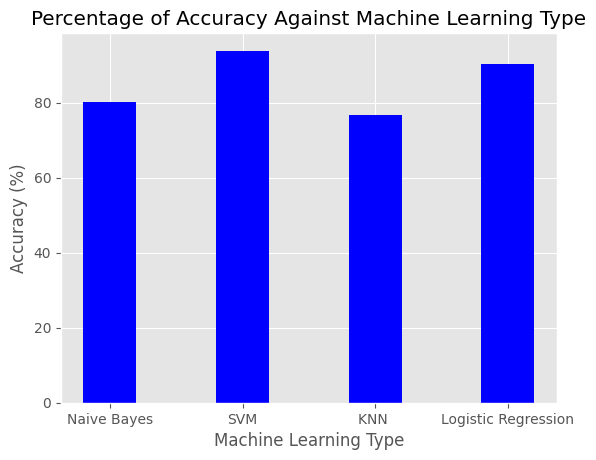

In [101]:
#plot graph for accuracies
plot_data = {"Naive Bayes" : NB_score, "SVM" : SVM_score, "KNN " : KNN_score, "Logistic Regression" : LR_score }
mac_learn_type = list(plot_data.keys())
accuracy = list(plot_data.values())

plt.bar(mac_learn_type,accuracy, color = 'blue', width = 0.4)

plt.xlabel("Machine Learning Type")
plt.ylabel("Accuracy (%)")
plt.title("Percentage of Accuracy Against Machine Learning Type")
plt.show()